# Directory

In [226]:
%cd /Users/mayanksharma/Desktop/Data Study Group/data

/Users/mayanksharma/Desktop/Data Study Group/data


# Algorithm

In [140]:
import numpy as np

import time
import matplotlib.pyplot as plt
from PIL import Image

def otsu(data, num=400, get_bcm=False):
    """
    generate binary change map based on otsu
    :param data: cluster data
    :param num: intensity number
    :param get_bcm: bool, get bcm or not
    :return:
        binary change map
        selected threshold
    """
    max_value = np.max(data)
    min_value = np.min(data)

    total_num = data.shape[1]
    step_value = (max_value - min_value) / num
    value = min_value + step_value
    best_threshold = min_value
    best_inter_class_var = 0
    while value <= max_value:
        data_1 = data[data <= value]
        data_2 = data[data > value]
        if data_1.shape[0] == 0 or data_2.shape[0] == 0:
            value += step_value
            continue
        w1 = data_1.shape[0] / total_num
        w2 = data_2.shape[0] / total_num

        mean_1 = data_1.mean()
        mean_2 = data_2.mean()

        inter_class_var = w1 * w2 * np.power((mean_1 - mean_2), 2)
        if best_inter_class_var < inter_class_var:
            best_inter_class_var = inter_class_var
            best_threshold = value
        value += step_value
    if get_bcm:
        bwp = np.zeros(data.shape)
        bwp[data <= best_threshold] = 0
        bwp[data > best_threshold] = 255
        print('otsu is done')
        return bwp, best_threshold
    else:
        print('otsu is done')
        return best_threshold

In [141]:
import numpy as np
from scipy.linalg import eig
from scipy.stats import chi2
from sklearn.cluster import KMeans

import time


class ISFA(object):
    def __init__(self, img_X, img_Y, data_format='CHW'):
        """
        the init function
        :param img_X: former temporal image, its dim is (band_count, width, height)
        :param img_Y: latter temporal image, its dim is (band_count, width, height)
        """
        if data_format == 'HWC':
            self.img_X = np.transpose(img_X, [2, 0, 1])
            self.img_Y = np.transpose(img_Y, [2, 0, 1])
        else:
            self.img_X = img_X
            self.img_Y = img_Y

        channel, height, width = self.img_X.shape
        self.L = np.zeros((channel - 2, channel))  # (C-2, C)
        for i in range(channel - 2):
            self.L[i, i] = 1
            self.L[i, i + 1] = -2
            self.L[i, i + 2] = 1
        self.Omega = np.dot(self.L.T, self.L)  # (C, C)
        self.norm_method = ['LSR', 'NR', 'OR']

    def isfa(self, max_iter=30, epsilon=1e-6, norm_trans=False, regular=False):
        """
         extract change and unchange info of temporal images based on USFA
         if max_iter == 1, ISFA is equal to SFA
        :param max_iter: the maximum count of iteration
        :param epsilon: convergence threshold
        :param norm_trans: whether normalize the transformation matrix
        :return:
            ISFA_variable: ISFA variable, its dim is (band_count, width * height)
            lamb: last lambda
            all_lambda: all lambda in convergence process
            trans_mat: transformation matrix
            T: last IWD, if max_iter == 1, T is chi-square distance
            weight: the unchanged probability of each pixel
        """

        bands_count, img_height, img_width = self.img_X.shape
        P = img_height * img_width
        # row-major order after reshape
        img_X = np.reshape(self.img_X, (-1, img_height * img_width))  # (band, width * height)
        img_Y = np.reshape(self.img_Y, (-1, img_height * img_width))  # (band, width * height)
        lamb = 100 * np.ones((bands_count, 1))
        all_lambda = []
        weight = np.ones((img_width, img_height))  # (1, width * height)
        # weight[302:343, 471] = 1  # init seed
        # weight[209, 231:250] = 1
        # weight[335:362, 570] = 1
        # weight[779, 332:387] = 1

        weight = np.reshape(weight, (-1, img_width * img_height))
        for _iter in range(max_iter):
            sum_w = np.sum(weight)
            mean_X = np.sum(weight * img_X, axis=1, keepdims=True) / np.sum(weight)  # (band, 1)
            mean_Y = np.sum(weight * img_Y, axis=1, keepdims=True) / np.sum(weight)  # (band, 1)
            center_X = (img_X - mean_X)
            center_Y = (img_Y - mean_Y)

            # cov_XY = covw(center_X, center_Y, weight)  # (2 * band, 2 * band)
            # cov_X = cov_XY[0:bands_count, 0:bands_count]
            # cov_Y = cov_XY[bands_count:2 * bands_count, bands_count:2 * bands_count]
            var_X = np.sum(weight * np.power(center_X, 2), axis=1, keepdims=True) / ((P - 1) * sum_w / P)
            var_Y = np.sum(weight * np.power(center_Y, 2), axis=1, keepdims=True) / ((P - 1) * sum_w / P)
            std_X = np.reshape(np.sqrt(var_X), (bands_count, 1))
            std_Y = np.reshape(np.sqrt(var_Y), (bands_count, 1))

            # normalize image
            norm_X = center_X / std_X
            norm_Y = center_Y / std_Y
            diff_img = (norm_X - norm_Y)
            mat_A = np.dot(weight * diff_img, diff_img.T) / ((P - 1) * sum_w / P)
            mat_B = (np.dot(weight * norm_X, norm_X.T) +
                     np.dot(weight * norm_Y, norm_Y.T)) / (2 * (P - 1) * sum_w / P)
            if regular:
                penalty = np.trace(mat_B) / np.trace(self.Omega)
                mat_B += penalty * self.Omega
            # solve generalized eigenvalue problem and get eigenvalues and eigenvector
            eigenvalue, eigenvector = eig(mat_A, mat_B)
            eigenvalue = eigenvalue.real  # discard imaginary part
            idx = eigenvalue.argsort()
            eigenvalue = eigenvalue[idx]

            # make sure the max absolute value of vector is 1,
            # and the final result will be more closer to the matlab result
            aux = np.reshape(np.abs(eigenvector).max(axis=0), (1, bands_count))
            eigenvector = eigenvector / aux

            # print sqrt(lambda)
            if (_iter + 1) == 1:
                print('sqrt lambda:')
            print(np.sqrt(eigenvalue))

            eigenvalue = np.reshape(eigenvalue, (bands_count, 1))  # (band, 1)
            threshold = np.max(np.abs(np.sqrt(lamb) - np.sqrt(eigenvalue)))
            # if sqrt(lambda) converge
            if threshold < epsilon:
                break
            lamb = eigenvalue
            all_lambda = lamb if (_iter + 1) == 1 else np.concatenate((all_lambda, lamb), axis=1)
            # the order of the slowest features is determined by the order of the eigenvalues
            trans_mat = eigenvector[:, idx]
            # satisfy the constraints(3)
            if norm_trans:
                output_signal_std = 1 / np.sqrt(np.diag(np.dot(trans_mat.T, np.dot(mat_B, trans_mat))))
                trans_mat = output_signal_std * trans_mat
            ISFA_variable = np.dot(trans_mat.T, norm_X) - np.dot(trans_mat.T, norm_Y)

            if (_iter + 1) == 1:
                T = np.sum(np.square(ISFA_variable) / np.sqrt(lamb), axis=0, keepdims=True)  # chi square
            else:
                T = np.sum(np.square(ISFA_variable) / np.sqrt(lamb), axis=0, keepdims=True)  # IWD
            weight = 1 - chi2.cdf(T, bands_count)

        if (_iter + 1) == max_iter:
            print('the lambda may not be converged')
        else:
            print('the lambda is converged, the iteration is %d' % (_iter + 1))

        return ISFA_variable, lamb, all_lambda, trans_mat, T, weight




# SK1091

In [298]:
upscale_factor = 1/3

with rasterio.open(r"SK1091_pre.tif") as dataset:

    # resample data to target shape using upscale_factor
    data1 = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    print('Shape before resample:', dataset.shape)
    print('Shape after resample:', data1.shape[1:])


Shape before resample: (8000, 8000)
Shape after resample: (2666, 2666)


In [299]:
with rasterio.open(r"SK1091_post.tif") as dataset:

    # resample data to target shape using upscale_factor
    data2 = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    print('Shape before resample:', dataset.shape)
    print('Shape after resample:', data2.shape[1:])


Shape before resample: (8000, 8000)
Shape after resample: (2666, 2666)


In [300]:
old_image = np.asarray(data1)

new_image = np.asarray(data2)
print(f'shape old and new image: {old_image.shape}, {new_image.shape}')

shape old and new image: (3, 2666, 2666), (3, 2666, 2666)


In [301]:
sfa = ISFA(old_image,new_image)
    # when max_iter is set to 1, ISFA becomes SFA
bn_SFA_variable, bn_lamb, bn_all_lambda, bn_trans_mat, bn_iwd, bn_isfa_w = sfa.isfa(max_iter=50, epsilon=1e-3,
                                                                                        norm_trans=True)

sqrt lambda:
[0.69757717 1.12365743 1.30540985]
[0.51718336 0.83260468 1.11403493]
[0.47443684 0.73417841 0.99664694]
[0.46216578 0.69867905 0.94326865]
[0.45852381 0.68530988 0.91950203]
[0.45756245 0.68020189 0.90898499]
[0.45748916 0.67827987 0.90434478]
[0.45771241 0.67761105 0.9023037 ]
[0.45802032 0.67743826 0.90141088]
the lambda is converged, the iteration is 9


In [302]:
sqrt_chi2 = np.sqrt(bn_iwd)
bcm = np.ones((1, 2666 * 2666))
thre = otsu(sqrt_chi2)
bcm[sqrt_chi2 > thre] = 255
bcm = np.reshape(bcm,(2666 , 2666))

otsu is done


In [303]:
print(f'old_image shape: {old_image.shape}')
# old_image_rehsaped = old_image.swapaxes(0,-1)
old_image_rehsaped = np.transpose(old_image,[1,2,0])
print(f'old_image_rehsaped shape: {old_image_rehsaped.shape}')

print(f'new_image shape: {new_image.shape}')
#new_image_rehsaped = new_image.swapaxes(0,-1)
new_image_rehsaped = np.transpose(new_image,[1,2,0])

print(f'new_image_rehsaped shape: {new_image_rehsaped.shape}')

old_image shape: (3, 2666, 2666)
old_image_rehsaped shape: (2666, 2666, 3)
new_image shape: (3, 2666, 2666)
new_image_rehsaped shape: (2666, 2666, 3)


In [304]:
old_image_rehsaped[:,:,1].shape

(2666, 2666)

In [305]:
joblib.dump(bcm,"outputSK1091.joblib")

['outputSK1091.joblib']

Text(0.5, 1.0, 'Binary Change Map')

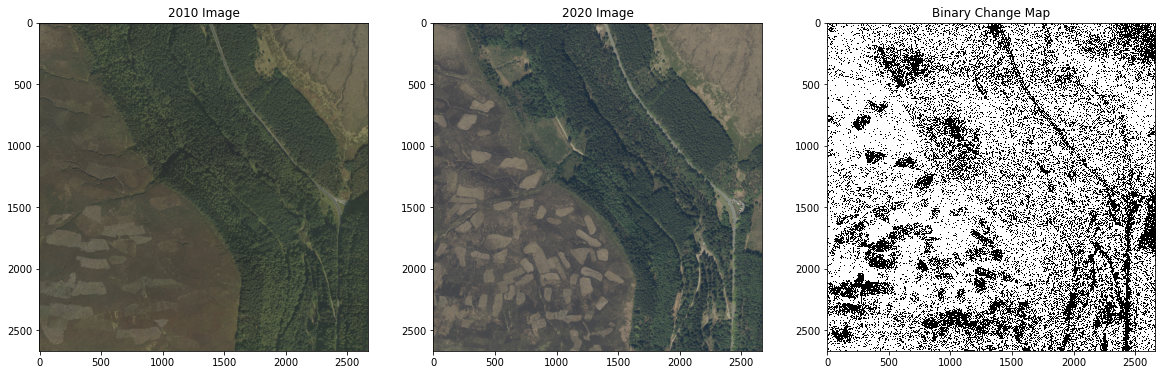

In [285]:
plt.subplots(1,3, figsize=(20,7))
plt.subplot(1,3,1)


with rasterio.open(r"SK1091_pre.tif") as dataset:

    # resample data to target shape using upscale_factor
    data1 = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )
plt.imshow(old_image_rehsaped)
plt.title("2010 Image")

plt.subplot(1,3,2)


with rasterio.open(r"SK1091_post.tif") as dataset:

    # resample data to target shape using upscale_factor
    data2 = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )
    

plt.imshow(new_image_rehsaped)
plt.title("2020 Image")

plt.subplot(1,3,3)

plt.imshow(bcm,cmap="binary",interpolation="none")


plt.title("Binary Change Map")

# SK0961

In [286]:
upscale_factor = 1/3

with rasterio.open(r"SK0961_pre.tif") as dataset:

    # resample data to target shape using upscale_factor
    data1 = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    print('Shape before resample:', dataset.shape)
    print('Shape after resample:', data1.shape[1:])

    
with rasterio.open(r"SK0961_post.tif") as dataset:

    # resample data to target shape using upscale_factor
    data2 = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    print('Shape before resample:', dataset.shape)
    print('Shape after resample:', data2.shape[1:])

    
old_image = np.asarray(data1)

new_image = np.asarray(data2)
print(f'shape old and new image: {old_image.shape}, {new_image.shape}')

sfa = ISFA(old_image,new_image)
    # when max_iter is set to 1, ISFA becomes SFA
bn_SFA_variable, bn_lamb, bn_all_lambda, bn_trans_mat, bn_iwd, bn_isfa_w = sfa.isfa(max_iter=50, epsilon=1e-3,
                                                                                        norm_trans=True)

Shape before resample: (8000, 8000)
Shape after resample: (2666, 2666)
Shape before resample: (8000, 8000)
Shape after resample: (2666, 2666)
shape old and new image: (3, 2666, 2666), (3, 2666, 2666)
sqrt lambda:
[1.10566798 1.30269104 1.38438982]
[0.96407435 1.12392437 1.22400618]
[0.88948636 1.02458175 1.11187858]
[0.85107427 0.95906167 1.04047671]
[0.82985409 0.92061391 1.00147347]
[0.81799859 0.89966613 0.98024645]
[0.8114825  0.88829709 0.96857424]
[0.80795136 0.88193237 0.96205963]
[0.80605334 0.8781751  0.95834271]
[0.80503679 0.87580599 0.95615485]
[0.80449312 0.87420854 0.95481361]
[0.8042033  0.87306769 0.95395108]
[0.80405071 0.87221744 0.95336771]
the lambda is converged, the iteration is 13


In [287]:
sqrt_chi2 = np.sqrt(bn_iwd)
bcm = np.ones((1, 2666 * 2666))
thre = otsu(sqrt_chi2)
bcm[sqrt_chi2 > thre] = 255
bcm = np.reshape(bcm,(2666 , 2666))

otsu is done


In [288]:
print(f'old_image shape: {old_image.shape}')
# old_image_rehsaped = old_image.swapaxes(0,-1)
old_image_rehsaped = np.transpose(old_image,[1,2,0])
print(f'old_image_rehsaped shape: {old_image_rehsaped.shape}')

print(f'new_image shape: {new_image.shape}')
#new_image_rehsaped = new_image.swapaxes(0,-1)
new_image_rehsaped = np.transpose(new_image,[1,2,0])

print(f'new_image_rehsaped shape: {new_image_rehsaped.shape}')

old_image shape: (3, 2666, 2666)
old_image_rehsaped shape: (2666, 2666, 3)
new_image shape: (3, 2666, 2666)
new_image_rehsaped shape: (2666, 2666, 3)


Text(0.5, 1.0, 'Binary Change Map')

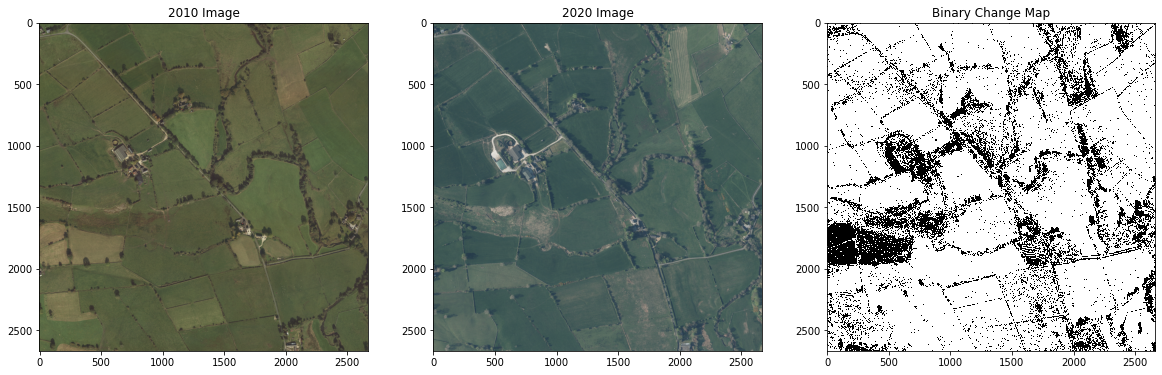

In [289]:
plt.subplots(1,3, figsize=(20,7))
plt.subplot(1,3,1)


with rasterio.open(r"SK0961_pre.tif") as dataset:

    # resample data to target shape using upscale_factor
    data1 = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )
plt.imshow(old_image_rehsaped)
plt.title("2010 Image")

plt.subplot(1,3,2)


with rasterio.open(r"SK0961_post.tif") as dataset:

    # resample data to target shape using upscale_factor
    data2 = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )
    

plt.imshow(new_image_rehsaped)
plt.title("2020 Image")

plt.subplot(1,3,3)

plt.imshow(bcm,cmap="binary",interpolation="none")


plt.title("Binary Change Map")

# SK2096

In [290]:
upscale_factor = 1/3

with rasterio.open(r"SK2096_pre.tif") as dataset:

    # resample data to target shape using upscale_factor
    data1 = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    print('Shape before resample:', dataset.shape)
    print('Shape after resample:', data1.shape[1:])

    
with rasterio.open(r"SK2096_post.tif") as dataset:

    # resample data to target shape using upscale_factor
    data2 = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    print('Shape before resample:', dataset.shape)
    print('Shape after resample:', data2.shape[1:])

    
old_image = np.asarray(data1)

new_image = np.asarray(data2)
print(f'shape old and new image: {old_image.shape}, {new_image.shape}')

sfa = ISFA(old_image,new_image)
    # when max_iter is set to 1, ISFA becomes SFA
bn_SFA_variable, bn_lamb, bn_all_lambda, bn_trans_mat, bn_iwd, bn_isfa_w = sfa.isfa(max_iter=50, epsilon=1e-3,
                                                                                        norm_trans=True)

Shape before resample: (8000, 8000)
Shape after resample: (2666, 2666)
Shape before resample: (8000, 8000)
Shape after resample: (2666, 2666)
shape old and new image: (3, 2666, 2666), (3, 2666, 2666)
sqrt lambda:
[1.00224205 1.26534274 1.37661939]
[0.77637149 1.01549706 1.12730611]
[0.67615202 0.89187569 0.98612246]
[0.61801334 0.83859801 0.92019228]
[0.5852805  0.81601348 0.88962529]
[0.5677784  0.80619222 0.87519398]
[0.55858465 0.80187843 0.8682924 ]
[0.55373088 0.80002085 0.8649852 ]
[0.55111349 0.79927343 0.86341777]
[0.54965131 0.79902545 0.86269654]
[0.54879452 0.79899631 0.86238549]
the lambda is converged, the iteration is 11


In [291]:
sqrt_chi2 = np.sqrt(bn_iwd)
bcm = np.ones((1, 2666 * 2666))
thre = otsu(sqrt_chi2)
bcm[sqrt_chi2 > thre] = 255
bcm = np.reshape(bcm,(2666 , 2666))

otsu is done


In [292]:
print(f'old_image shape: {old_image.shape}')
# old_image_rehsaped = old_image.swapaxes(0,-1)
old_image_rehsaped = np.transpose(old_image,[1,2,0])
print(f'old_image_rehsaped shape: {old_image_rehsaped.shape}')

print(f'new_image shape: {new_image.shape}')
#new_image_rehsaped = new_image.swapaxes(0,-1)
new_image_rehsaped = np.transpose(new_image,[1,2,0])

print(f'new_image_rehsaped shape: {new_image_rehsaped.shape}')

old_image shape: (3, 2666, 2666)
old_image_rehsaped shape: (2666, 2666, 3)
new_image shape: (3, 2666, 2666)
new_image_rehsaped shape: (2666, 2666, 3)


Text(0.5, 1.0, 'Binary Change Map')

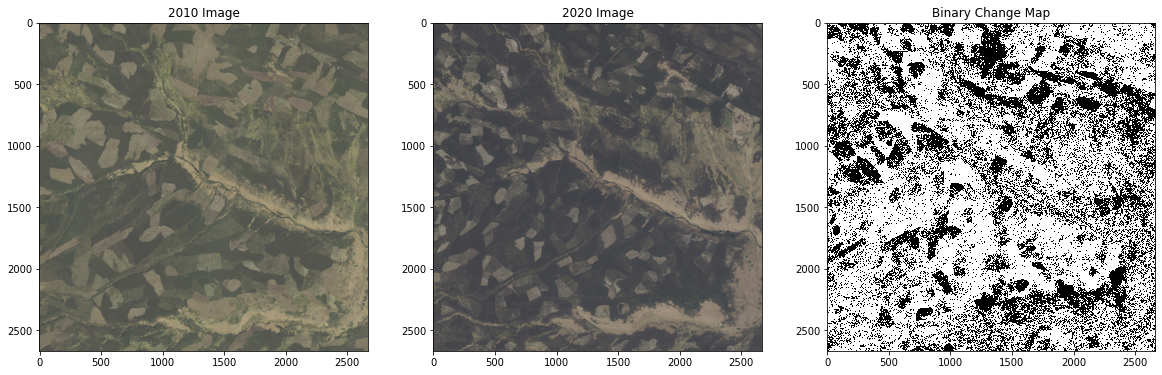

In [293]:
plt.subplots(1,3, figsize=(20,7))
plt.subplot(1,3,1)


with rasterio.open(r"SK2096_pre.tif") as dataset:

    # resample data to target shape using upscale_factor
    data1 = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )
plt.imshow(old_image_rehsaped)
plt.title("2010 Image")

plt.subplot(1,3,2)


with rasterio.open(r"SK2096_post.tif") as dataset:

    # resample data to target shape using upscale_factor
    data2 = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )
    

plt.imshow(new_image_rehsaped)
plt.title("2020 Image")

plt.subplot(1,3,3)

plt.imshow(bcm,cmap="binary",interpolation="none")


plt.title("Binary Change Map")

# SK0987

In [294]:
upscale_factor = 1/3

with rasterio.open(r"SK0987_pre.tif") as dataset:

    # resample data to target shape using upscale_factor
    data1 = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    print('Shape before resample:', dataset.shape)
    print('Shape after resample:', data1.shape[1:])

    
with rasterio.open(r"SK0987_post.tif") as dataset:

    # resample data to target shape using upscale_factor
    data2 = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    print('Shape before resample:', dataset.shape)
    print('Shape after resample:', data2.shape[1:])

    
old_image = np.asarray(data1)

new_image = np.asarray(data2)
print(f'shape old and new image: {old_image.shape}, {new_image.shape}')

sfa = ISFA(old_image,new_image)
    # when max_iter is set to 1, ISFA becomes SFA
bn_SFA_variable, bn_lamb, bn_all_lambda, bn_trans_mat, bn_iwd, bn_isfa_w = sfa.isfa(max_iter=50, epsilon=1e-3,
                                                                                        norm_trans=True)

Shape before resample: (8000, 8000)
Shape after resample: (2666, 2666)
Shape before resample: (8000, 8000)
Shape after resample: (2666, 2666)
shape old and new image: (3, 2666, 2666), (3, 2666, 2666)
sqrt lambda:
[1.0661676  1.10973305 1.43748363]
[0.86206332 0.96811433 1.20080984]
[0.81120106 0.91925774 1.09060597]
[0.79541107 0.89580567 1.0375881 ]
[0.78585456 0.88407632 1.00737471]
[0.77957833 0.87760978 0.9883309 ]
[0.77555664 0.87386422 0.97588667]
[0.77295446 0.871685   0.96764292]
[0.77121187 0.87043372 0.96213012]
[0.769992   0.86972915 0.95840344]
[0.76909963 0.86934174 0.95584917]
[0.76842193 0.86913513 0.95406915]
[0.76789232 0.86902975 0.95280555]
[0.76746997 0.86897992 0.95189119]
the lambda is converged, the iteration is 14


In [295]:
sqrt_chi2 = np.sqrt(bn_iwd)
bcm = np.ones((1, 2666 * 2666))
thre = otsu(sqrt_chi2)
bcm[sqrt_chi2 > thre] = 255
bcm = np.reshape(bcm,(2666 , 2666))

otsu is done


In [296]:
print(f'old_image shape: {old_image.shape}')
# old_image_rehsaped = old_image.swapaxes(0,-1)
old_image_rehsaped = np.transpose(old_image,[1,2,0])
print(f'old_image_rehsaped shape: {old_image_rehsaped.shape}')

print(f'new_image shape: {new_image.shape}')
#new_image_rehsaped = new_image.swapaxes(0,-1)
new_image_rehsaped = np.transpose(new_image,[1,2,0])

print(f'new_image_rehsaped shape: {new_image_rehsaped.shape}')

old_image shape: (3, 2666, 2666)
old_image_rehsaped shape: (2666, 2666, 3)
new_image shape: (3, 2666, 2666)
new_image_rehsaped shape: (2666, 2666, 3)


Text(0.5, 1.0, 'Binary Change Map')

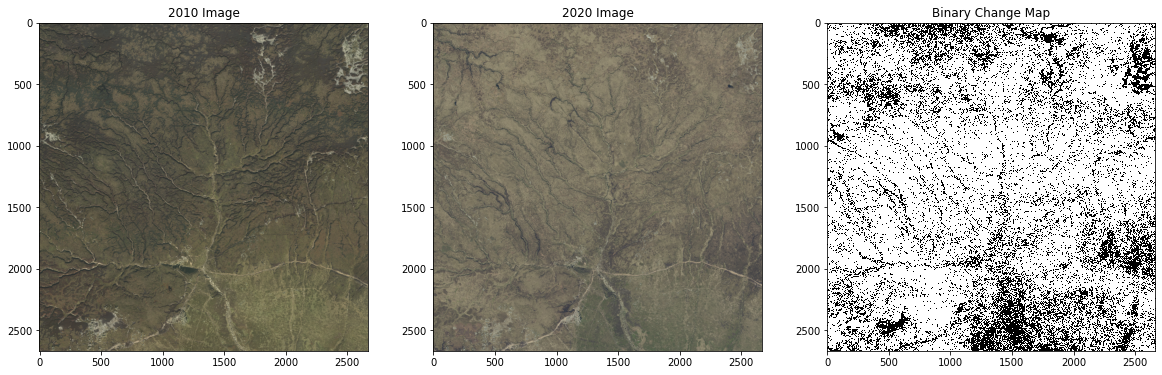

In [297]:
plt.subplots(1,3, figsize=(20,7))
plt.subplot(1,3,1)


with rasterio.open(r"SK0987_pre.tif") as dataset:

    # resample data to target shape using upscale_factor
    data1 = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )
plt.imshow(old_image_rehsaped)
plt.title("2010 Image")

plt.subplot(1,3,2)


with rasterio.open(r"SK0987_post.tif") as dataset:

    # resample data to target shape using upscale_factor
    data2 = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )
    

plt.imshow(new_image_rehsaped)
plt.title("2020 Image")

plt.subplot(1,3,3)

plt.imshow(bcm,cmap="binary",interpolation="none")


plt.title("Binary Change Map")